# Business Problem
This is a dataset from one bank in the United States. Besides usual services, this bank also provides car insurance services. The bank organizes regular campaigns to attract new clients. The bank has potential customers’ data, and bank’s employees call them for advertising available car insurance options.

We are provided with general information about clients (age, job, etc.) as well as more specific information about the current insurance sell campaign (communication, last contact day) and previous campaigns (attributes like previous attempts, outcome).

You have data about 4000 customers who were contacted during the last campaign and for whom the results of campaign (did the customer buy insurance or not) are known.

Task and Approach:
The task is to predict for 1000 customers who were contacted during the current campaign, whether they will buy car insurance or not.

We will be using Boosting technique (XG BOOST & GBM) to predict it

# Step 1 : Importing Libraries and Understanding Data
Numpy, pandas , seaborn and matplotlib.pyplot are imported with aliases np, pd, sns and plt respectively

In [1]:
%matplotlib inline  
# To make data visualisations display in Jupyter Notebooks 
import numpy as np   # linear algebra
import pandas as pd  # Data processing, Input & Output load
import matplotlib.pyplot as plt # Visuvalization & plotting
import datetime  

import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from xgboost.sklearn import XGBClassifier # Extrame GB
from xgboost import plot_importance ## Plotting Importance Variables 

import joblib  #Joblib is a set of tools to provide lightweight pipelining in Python (Avoid computing twice the same thing)

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
                                    # GridSearchCV - Implements a “fit” and a “score” method
                                    # train_test_split - Split arrays or matrices into random train and test subsets
                                    # cross_val_score - Evaluate a score by cross-validation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score, make_scorer, accuracy_score, roc_curve, confusion_matrix, classification_report                                    # Differnt metrics to evaluate the model 
import pandas_profiling as pp   # simple and fast exploratory data analysis of a Pandas Datafram

import warnings   # To avoid warning messages in the code run
warnings.filterwarnings("ignore")

# User Defined Functions

In [3]:
def plot_roc_curve(y_train_actual, train_pred_prob, y_test_actual, test_pred_prob, *args):
    '''
    Generate the train & test roc curve
    '''

    AUC_Train = roc_auc_score(y_train_actual, train_pred_prob)
    AUC_Test = roc_auc_score(y_test_actual, test_pred_prob)

    if len(args) == 0:
        print("Train AUC = ", AUC_Train)
        print("Test AUC = ", AUC_Test)
        fpr, tpr, thresholds = roc_curve(y_train_actual, train_pred_prob)
        fpr_tst, tpr_tst, thresholds = roc_curve(y_test_actual, test_pred_prob)
        roc_plot(fpr, tpr, fpr_tst, tpr_tst)

    else:
        AUC_Valid = roc_auc_score(args[0], args[1])
        print("Train AUC = ", AUC_Train)
        print("Test AUC = ", AUC_Test)
        print("Validation AUC = ", AUC_Valid)
        fpr, tpr, thresholds = roc_curve(y_train_actual, train_pred_prob)
        fpr_tst, tpr_tst, thresholds = roc_curve(y_test_actual, test_pred_prob)
        fpr_val, tpr_val, thresholds = roc_curve(args[0], args[1])
        roc_plot(fpr, tpr, fpr_tst, tpr_tst, fpr_val, tpr_val)

In [4]:
def roc_plot(fpr, tpr, fpr_tst, tpr_tst, *args):
    '''
    Generates roc plot
    '''

    fig = plt.plot(fpr, tpr, label='Train')
    fig = plt.plot(fpr_tst, tpr_tst, label='Test')

    if len(args) == 0:
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title("ROC curve using ")
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    else:
        fig = plt.plot(args[0], args[1], label='Validation')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title("ROC curve using ")
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

# Load Data

In [6]:
# Read-in the dataset
Insurance_Data = pd.read_csv('D:\\Data_science_project\\Data_science_project\\carInsurance_xgb_boosting\\carInsurance_train.csv')
print('Train Data Shape - ', Insurance_Data.shape)
Insurance_Data.head()

Train Data Shape -  (4000, 19)


Id  Age          Job  Marital Education  Default  Balance  HHInsurance  \
0   1   32   management   single  tertiary        0     1218            1   
1   2   32  blue-collar  married   primary        0     1156            1   
2   3   29   management   single  tertiary        0      637            1   
3   4   25      student   single   primary        0      373            1   
4   5   30   management  married  tertiary        0     2694            0   

   CarLoan Communication  LastContactDay LastContactMonth  NoOfContacts  \
0        0     telephone              28              jan             2   
1        0           NaN              26              may             5   
2        0      cellular               3              jun             1   
3        0      cellular              11              may             2   
4        0      cellular               3              jun             1   

   DaysPassed  PrevAttempts  Outcome CallStart   CallEnd  CarInsurance  
0          -1             0      NaN  13:45:20  13:46:30             0  
1          -1             0      NaN  14:49:03  14:52:08             0  
2         119             1  failure  16:30:24  16:36:04             1  
3          -1             0      NaN  12:06:43  12:20:22             1  
4          -1             0      NaN  14:35:44  14:38:56             0

We have 4000 customers of data with 19 columns to train the model and 1000 customers to test our model on. Here we will use the train and test data differently to train and test the model.

In [7]:
# What type of values are stored in the columns?
Insurance_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                4000 non-null   int64 
 1   Age               4000 non-null   int64 
 2   Job               3981 non-null   object
 3   Marital           4000 non-null   object
 4   Education         3831 non-null   object
 5   Default           4000 non-null   int64 
 6   Balance           4000 non-null   int64 
 7   HHInsurance       4000 non-null   int64 
 8   CarLoan           4000 non-null   int64 
 9   Communication     3098 non-null   object
 10  LastContactDay    4000 non-null   int64 
 11  LastContactMonth  4000 non-null   object
 12  NoOfContacts      4000 non-null   int64 
 13  DaysPassed        4000 non-null   int64 
 14  PrevAttempts      4000 non-null   int64 
 15  Outcome           958 non-null    object
 16  CallStart         4000 non-null   object
 17  CallEnd       

In [8]:
pp.ProfileReport(Insurance_Data)

# EDA

In [9]:
# Let's look at some statistical information about our dataframe.
Insurance_Data.describe()

Id          Age      Default       Balance  HHInsurance  \
count  4000.000000  4000.000000  4000.000000   4000.000000   4000.00000   
mean   2000.500000    41.214750     0.014500   1532.937250      0.49275   
std    1154.844867    11.550194     0.119555   3511.452489      0.50001   
min       1.000000    18.000000     0.000000  -3058.000000      0.00000   
25%    1000.750000    32.000000     0.000000    111.000000      0.00000   
50%    2000.500000    39.000000     0.000000    551.500000      0.00000   
75%    3000.250000    49.000000     0.000000   1619.000000      1.00000   
max    4000.000000    95.000000     1.000000  98417.000000      1.00000   

           CarLoan  LastContactDay  NoOfContacts   DaysPassed  PrevAttempts  \
count  4000.000000     4000.000000   4000.000000  4000.000000   4000.000000   
mean      0.133000       15.721250      2.607250    48.706500      0.717500   
std       0.339617        8.425307      3.064204   106.685385      2.078647   
min       0.000000        1.000000      1.000000    -1.000000      0.000000   
25%       0.000000        8.000000      1.000000    -1.000000      0.000000   
50%       0.000000       16.000000      2.000000    -1.000000      0.000000   
75%       0.000000       22.000000      3.000000    -1.000000      0.000000   
max       1.000000       31.000000     43.000000   854.000000     58.000000   

       CarInsurance  
count   4000.000000  
mean       0.401000  
std        0.490162  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000

In [10]:
# This is how we can get summary for the categorical data
Insurance_Data.describe(include=np.object) 

Job  Marital  Education Communication LastContactMonth  \
count         3981     4000       3831          3098             4000   
unique          11        3          3             2               12   
top     management  married  secondary      cellular              may   
freq           893     2304       1988          2831             1049   

        Outcome CallStart   CallEnd  
count       958      4000      4000  
unique        3      3777      3764  
top     failure  10:42:44  10:52:24  
freq        437         3         3

# Univariate Analysis
Lets analyse the data w.r.t our Target variable

In [11]:
Target = 'CarInsurance'
pd.crosstab(Insurance_Data[Target], columns='N', normalize=True)

col_0             N
CarInsurance       
0             0.599
1             0.401

The data seems to be quiet good as we have approx. 40% of 1's in our data

# Visualising Data - Bivariate

In [12]:
Insurance_Data.head()

Id  Age          Job  Marital Education  Default  Balance  HHInsurance  \
0   1   32   management   single  tertiary        0     1218            1   
1   2   32  blue-collar  married   primary        0     1156            1   
2   3   29   management   single  tertiary        0      637            1   
3   4   25      student   single   primary        0      373            1   
4   5   30   management  married  tertiary        0     2694            0   

   CarLoan Communication  LastContactDay LastContactMonth  NoOfContacts  \
0        0     telephone              28              jan             2   
1        0           NaN              26              may             5   
2        0      cellular               3              jun             1   
3        0      cellular              11              may             2   
4        0      cellular               3              jun             1   

   DaysPassed  PrevAttempts  Outcome CallStart   CallEnd  CarInsurance  
0          -1             0      NaN  13:45:20  13:46:30             0  
1          -1             0      NaN  14:49:03  14:52:08             0  
2         119             1  failure  16:30:24  16:36:04             1  
3          -1             0      NaN  12:06:43  12:20:22             1  
4          -1             0      NaN  14:35:44  14:38:56             0

In [13]:
num_cols = Insurance_Data.select_dtypes(include=[np.number]).columns.tolist()
non_num_cols = Insurance_Data.select_dtypes(exclude=[np.number]).columns.tolist()

In [14]:
# Lets drop columns which we will not use
num_cols = Insurance_Data.drop(['Id', 'CarInsurance'],axis=1).select_dtypes(include=[np.number]).columns.tolist()
non_num_cols = Insurance_Data.drop(['CallStart', 'CallEnd'],axis=1).select_dtypes(exclude=[np.number]).columns.tolist()

In [15]:
print('Numeric Columns \n', num_cols)
print('Non-Numeric Columns \n', non_num_cols)

Numeric Columns 
 ['Age', 'Default', 'Balance', 'HHInsurance', 'CarLoan', 'LastContactDay', 'NoOfContacts', 'DaysPassed', 'PrevAttempts']
Non-Numeric Columns 
 ['Job', 'Marital', 'Education', 'Communication', 'LastContactMonth', 'Outcome']


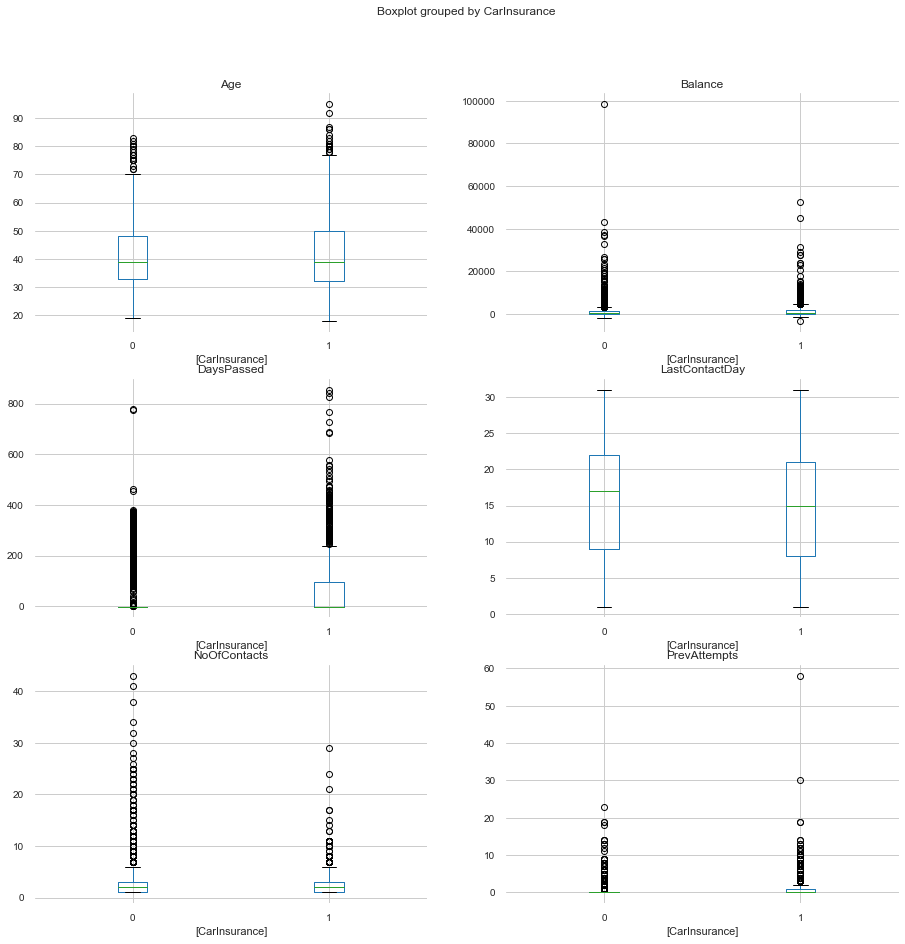

In [16]:
# Lets drop CarLoan, HHInsurance, Default from the numeric columns as these are dummies
num_cols_viz = ['DaysPassed', 'Age', 'NoOfContacts', 'PrevAttempts', 'LastContactDay', 'Balance']

fig, axes = plt.subplots(3,2,sharex=False,sharey=False, figsize=(15,15))
Insurance_Data.loc[:,[Target]+num_cols_viz].boxplot(by=Target, ax=axes,return_type='axes');

The "LastContactDay" boxplot clearly shows that longer since the last contact higher the chance that the person will not buy the Insurance

The "DaysPassed" boxplot shows that higher the number of days passes higher the chance that the person will buy the Insurance

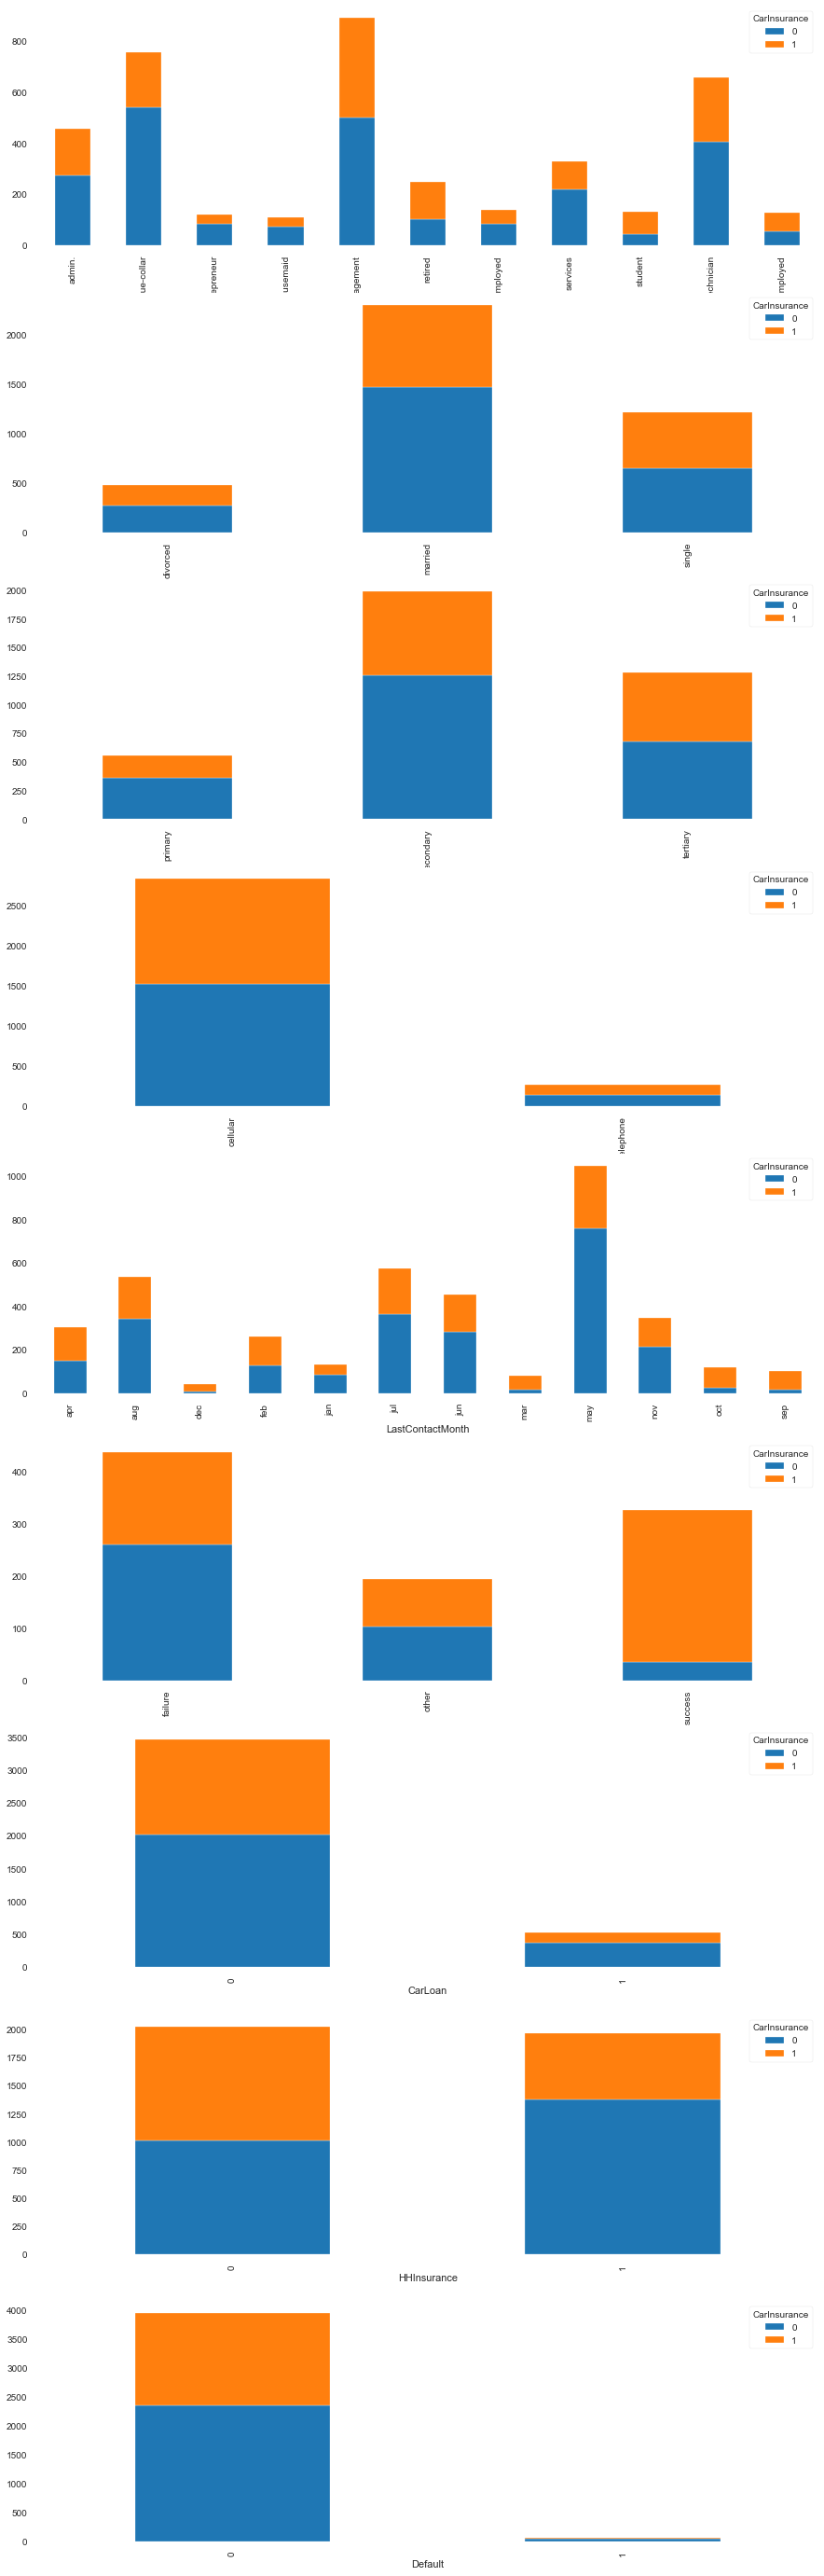

In [17]:
non_num_cols_viz = non_num_cols+['CarLoan', 'HHInsurance', 'Default']
fig, axes = plt.subplots(len(non_num_cols_viz),sharex=False,sharey=False, figsize=(15,50))
for i in range(len(non_num_cols_viz)):
    pd.crosstab(Insurance_Data[non_num_cols_viz[i]], Insurance_Data[Target]).plot(kind='bar', stacked=True, grid=False, ax=axes[i])
      

The JobType='Retired' seem to have higher chance of buying insurance

The Communication='cellular' seem to best way to reach out for carinsurance

In [18]:
Insurance_Data.isnull().sum()

Id                     0
Age                    0
Job                   19
Marital                0
Education            169
Default                0
Balance                0
HHInsurance            0
CarLoan                0
Communication        902
LastContactDay         0
LastContactMonth       0
NoOfContacts           0
DaysPassed             0
PrevAttempts           0
Outcome             3042
CallStart              0
CallEnd                0
CarInsurance           0
dtype: int64

In [19]:
Insurance_Data_Org = Insurance_Data.copy()

In [20]:
Insurance_Data['Job'].value_counts(dropna=False)

management       893
blue-collar      759
technician       660
admin.           459
services         330
retired          249
self-employed    140
student          131
unemployed       130
entrepreneur     121
housemaid        109
NaN               19
Name: Job, dtype: int64

In [21]:
Insurance_Data['Job'] = Insurance_Data['Job'].fillna('None')
Insurance_Data['Job'].isnull().sum()

0

# Missing Values - Education

In [22]:
# Fill missing education with the most common education level by job type
Insurance_Data['Education'].value_counts()

# Create job-education level mode mapping
edu_mode=[]

# What are different Job Types
job_types = Insurance_Data.Job.value_counts().index

# Checking which job is most 
Insurance_Data['Job'].value_counts()

management       893
blue-collar      759
technician       660
admin.           459
services         330
retired          249
self-employed    140
student          131
unemployed       130
entrepreneur     121
housemaid        109
None              19
Name: Job, dtype: int64

In [23]:
# Now according to the job type we will crate a mapping where the job and mode of education is there.
# It means when there are many people in the management job then most of them are in which education.
# We can find that in below mapping

for job in job_types:
    mode = Insurance_Data[Insurance_Data.Job==job]['Education'].value_counts().nlargest(1).index
    edu_mode = np.append(edu_mode,mode)
edu_map=pd.Series(edu_mode,index=Insurance_Data.Job.value_counts().index)

edu_map

management        tertiary
blue-collar      secondary
technician       secondary
admin.           secondary
services         secondary
retired          secondary
self-employed     tertiary
student          secondary
unemployed       secondary
entrepreneur      tertiary
housemaid          primary
None             secondary
dtype: object

In [24]:
# Apply the mapping to missing eductaion obs. We will replace education now by jobs value
for j in job_types:
    Insurance_Data.loc[(Insurance_Data['Education'].isnull()) & (Insurance_Data['Job']==j),'Education'] = edu_map.loc[edu_map.index==j][0]

# For those who are not getting mapped we will create a new category as None
Insurance_Data['Education'].fillna('None',inplace=True)

# Missing Value - Communication

In [25]:
# Fill missing communication with none
Insurance_Data['Communication'].value_counts(dropna=False)

cellular     2831
NaN           902
telephone     267
Name: Communication, dtype: int64

In [26]:
Insurance_Data['Communication'] = Insurance_Data['Communication'].fillna('None')

# Missing Value - Outcome

In [27]:
# Check for missing value in Outcome
Insurance_Data['Outcome'].value_counts(dropna=False)

NaN        3042
failure     437
success     326
other       195
Name: Outcome, dtype: int64

In [28]:
# Fill missing outcome as not in previous campaign, we are adding one category to Outcome
# We will add category if the value of DaysPassed is -1
# Can you do it other ways.. yes this is one way of doing you can do it other ways also.

Insurance_Data.loc[Insurance_Data['DaysPassed']==-1,'Outcome']='NoPrev'
Insurance_Data['Outcome'].value_counts(dropna=False)

NoPrev     3042
failure     437
success     326
other       195
Name: Outcome, dtype: int64

In [29]:
# Check if we have any missing values left
Insurance_Data.isnull().sum()

Id                  0
Age                 0
Job                 0
Marital             0
Education           0
Default             0
Balance             0
HHInsurance         0
CarLoan             0
Communication       0
LastContactDay      0
LastContactMonth    0
NoOfContacts        0
DaysPassed          0
PrevAttempts        0
Outcome             0
CallStart           0
CallEnd             0
CarInsurance        0
dtype: int64

# Create Model Dataset

In [30]:
Insurance_Data_num = Insurance_Data[num_cols+['Id', 'CarInsurance']]

In [31]:
# Categorical columns data
Insurance_Data_cat = Insurance_Data[non_num_cols]
non_num_cols

['Job', 'Marital', 'Education', 'Communication', 'LastContactMonth', 'Outcome']

In [32]:
# Create dummies
Insurance_Data_cat_dummies = pd.get_dummies(Insurance_Data_cat)
print(Insurance_Data_cat_dummies.shape)
Insurance_Data_cat_dummies.head()

(4000, 37)


Job_None  Job_admin.  Job_blue-collar  Job_entrepreneur  Job_housemaid  \
0         0           0                0                 0              0   
1         0           0                1                 0              0   
2         0           0                0                 0              0   
3         0           0                0                 0              0   
4         0           0                0                 0              0   

   Job_management  Job_retired  Job_self-employed  Job_services  Job_student  \
0               1            0                  0             0            0   
1               0            0                  0             0            0   
2               1            0                  0             0            0   
3               0            0                  0             0            1   
4               1            0                  0             0            0   

   ...  LastContactMonth_jun  LastContactMonth_mar  LastContactMonth_may  \
0  ...                     0                     0                     0   
1  ...                     0                     0                     1   
2  ...                     1                     0                     0   
3  ...                     0                     0                     1   
4  ...                     1                     0                     0   

   LastContactMonth_nov  LastContactMonth_oct  LastContactMonth_sep  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   Outcome_NoPrev  Outcome_failure  Outcome_other  Outcome_success  
0               1                0              0                0  
1               1                0              0                0  
2               0                1              0                0  
3               1                0              0                0  
4               1                0              0                0  

[5 rows x 37 columns]

In [33]:
Insurance_Data_final = pd.concat([Insurance_Data_num, Insurance_Data_cat_dummies], axis=1)
print(Insurance_Data_final.shape)
Insurance_Data_final.head()

(4000, 48)


Age  Default  Balance  HHInsurance  CarLoan  LastContactDay  NoOfContacts  \
0   32        0     1218            1        0              28             2   
1   32        0     1156            1        0              26             5   
2   29        0      637            1        0               3             1   
3   25        0      373            1        0              11             2   
4   30        0     2694            0        0               3             1   

   DaysPassed  PrevAttempts  Id  ...  LastContactMonth_jun  \
0          -1             0   1  ...                     0   
1          -1             0   2  ...                     0   
2         119             1   3  ...                     1   
3          -1             0   4  ...                     0   
4          -1             0   5  ...                     1   

   LastContactMonth_mar  LastContactMonth_may  LastContactMonth_nov  \
0                     0                     0                     0   
1                     0                     1                     0   
2                     0                     0                     0   
3                     0                     1                     0   
4                     0                     0                     0   

   LastContactMonth_oct  LastContactMonth_sep  Outcome_NoPrev  \
0                     0                     0               1   
1                     0                     0               1   
2                     0                     0               0   
3                     0                     0               1   
4                     0                     0               1   

   Outcome_failure  Outcome_other  Outcome_success  
0                0              0                0  
1                0              0                0  
2                1              0                0  
3                0              0                0  
4                0              0                0  

[5 rows x 48 columns]

In [34]:
# Checking if there are missing values before we run model
Insurance_Data_final.isnull().sum(axis = 0)

Age                        0
Default                    0
Balance                    0
HHInsurance                0
CarLoan                    0
LastContactDay             0
NoOfContacts               0
DaysPassed                 0
PrevAttempts               0
Id                         0
CarInsurance               0
Job_None                   0
Job_admin.                 0
Job_blue-collar            0
Job_entrepreneur           0
Job_housemaid              0
Job_management             0
Job_retired                0
Job_self-employed          0
Job_services               0
Job_student                0
Job_technician             0
Job_unemployed             0
Marital_divorced           0
Marital_married            0
Marital_single             0
Education_primary          0
Education_secondary        0
Education_tertiary         0
Communication_None         0
Communication_cellular     0
Communication_telephone    0
LastContactMonth_apr       0
LastContactMonth_aug       0
LastContactMon

# Split Data

In [35]:
train_df = Insurance_Data_final.drop(['Id', 'CarInsurance'], axis=1)
train_label = Insurance_Data_final['CarInsurance']

In [36]:
#random_state is the seed used by the random number generator. It can be any integer.
# Train test split
X_train, X_test, y_train, y_test = train_test_split(train_df, train_label, train_size=0.7 , random_state=100)

In [37]:
print('Train shape - ', X_train.shape)
print('Test shape  - ', X_test.shape)

Train shape -  (2800, 46)
Test shape  -  (1200, 46)


# Model 1 - XGBOOST

In [38]:
# Define Model parameters to tune
model_parameters = { 
        'n_estimators':[10, 50, 100, 200, 500, 750, 100],
        'max_depth': [3, 5, 10],
        'min_samples_leaf': [np.random.randint(1,10)],
        'max_features': [None, 'sqrt', 'log2']
                  }

In [39]:
# Gridsearch the parameters to find the best parameters. Using L2 penalty
model = XGBClassifier()
gscv = GridSearchCV(estimator=model, 
                    param_grid=model_parameters, 
                    cv=5, 
                    verbose=1, 
                    n_jobs=-1,
                    scoring='roc_auc')

gscv.fit(X_train, y_train)  ## Model building 

Fitting 5 folds for each of 63 candidates, totalling 315 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 315 out of 315 | elapsed:  2.3min finished


[20:10:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [40]:
print('The best parameter are -', gscv.best_params_)

The best parameter are - {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 50}


In [41]:
# Re-fit the model with the best parameters
final_mod = XGBClassifier(**gscv.best_params_)
final_mod.fit(X_train, y_train)

[20:10:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              max_features=None, min_child_weight=1, min_samples_leaf=1,
              missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [42]:
# Prediction
train_pred = final_mod.predict(X_train)
test_pred = final_mod.predict(X_test)

In [43]:
print('Classification report for train data is : \n',
      classification_report(y_train, train_pred))
print('Classification report for test data is : \n',
      classification_report(y_test, test_pred))

Classification report for train data is : 
               precision    recall  f1-score   support

           0       0.76      0.92      0.83      1663
           1       0.83      0.58      0.68      1137

    accuracy                           0.78      2800
   macro avg       0.80      0.75      0.76      2800
weighted avg       0.79      0.78      0.77      2800

Classification report for test data is : 
               precision    recall  f1-score   support

           0       0.76      0.89      0.82       733
           1       0.77      0.55      0.64       467

    accuracy                           0.76      1200
   macro avg       0.76      0.72      0.73      1200
weighted avg       0.76      0.76      0.75      1200



The F1-score seems to be not so consistent on train & test. Whenever any of the parameters touch the boundary we can extend the values to see if we could go further to idnetify optimal value.

In [44]:
# Save the variables used in the model as it will be required in future for new datasets prediction
final_mod.variables = X_train.columns

# Save Best Model

In [45]:
joblib.dump(final_mod, 'best_model.joblib')

['best_model.joblib']

# Evaluation

Train AUC =  0.8415709812246573
Test AUC =  0.7700044696197317


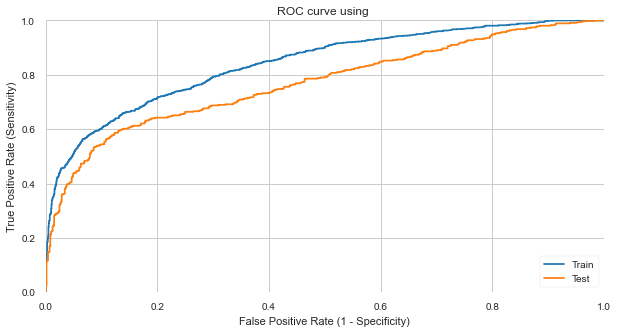

In [46]:
# Generate ROC
plt.subplots(figsize=(10, 5))
train_prob = final_mod.predict_proba(X_train)[:, 1]
test_prob = final_mod.predict_proba(X_test)[:, 1]

plot_roc_curve(y_train, train_prob,
               y_test, test_prob)

In [47]:
# make predictions for test data
y_pred = final_mod.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 75.92%


# Apply Model on Test Data

In [48]:
# Load the saved model

best_model = joblib.load('best_model.joblib')

In [50]:
# Load the test data
Insurance_test = pd.read_csv('D:\\Data_science_project\\Data_science_project\\carInsurance_xgb_boosting\\carInsurance_test.csv')
print('Test Data Shape  - ', Insurance_test.shape)
Insurance_test.head()

Test Data Shape  -  (1000, 19)


Id  Age         Job  Marital  Education  Default  Balance  HHInsurance  \
0  4001   25      admin.   single  secondary        0        1            1   
1  4002   40  management  married   tertiary        0        0            1   
2  4003   44  management   single   tertiary        0    -1313            1   
3  4004   27    services   single  secondary        0     6279            1   
4  4005   53  technician  married  secondary        0     7984            1   

   CarLoan Communication  LastContactDay LastContactMonth  NoOfContacts  \
0        1           NaN              12              may            12   
1        1      cellular              24              jul             1   
2        1      cellular              15              may            10   
3        0      cellular               9              nov             1   
4        0      cellular               2              feb             1   

   DaysPassed  PrevAttempts Outcome CallStart   CallEnd  CarInsurance  
0          -1             0     NaN  17:17:42  17:18:06           NaN  
1          -1             0     NaN  09:13:44  09:14:37           NaN  
2          -1             0     NaN  15:24:07  15:25:51           NaN  
3          -1             0     NaN  09:43:44  09:48:01           NaN  
4          -1             0     NaN  16:31:51  16:34:22           NaN

In [51]:
# Handle missing values on the test data
# The function takes the dataframe and does the same preprocessing that was done for train data

def handle_missing_values(df):
    #Job 
    df['Job'] = df['Job'].fillna('None')
    
    #Education
    # Apply the mapping to missing eductaion obs. We will replace education now by jobs value
    for j in job_types:
        df.loc[(df['Education'].isnull()) & (df['Job']==j),'Education'] = edu_map.loc[edu_map.index==j][0]

    # For those who are not getting mapped we will create a new category as None
    df['Education'] = df['Education'].fillna('None')
    
    #Communication
    df['Communication'] = df['Communication'].fillna('None')
    
    #Outcome
    df.loc[df['DaysPassed']==-1,'Outcome']='NoPrev'
    
    return df

In [52]:
Insurance_test_Org = Insurance_test.copy()

In [53]:
# Handle the missing values the same we had done for Train
Insurance_test = handle_missing_values(Insurance_test)

In [54]:
Insurance_test.isnull().sum()

Id                     0
Age                    0
Job                    0
Marital                0
Education              0
Default                0
Balance                0
HHInsurance            0
CarLoan                0
Communication          0
LastContactDay         0
LastContactMonth       0
NoOfContacts           0
DaysPassed             0
PrevAttempts           0
Outcome                0
CallStart              0
CallEnd                0
CarInsurance        1000
dtype: int64

In [55]:
# Convert Categorical to dummies
dummy_cols = pd.get_dummies(Insurance_test[non_num_cols])
dummy_cols.head()

Job_None  Job_admin.  Job_blue-collar  Job_entrepreneur  Job_housemaid  \
0         0           1                0                 0              0   
1         0           0                0                 0              0   
2         0           0                0                 0              0   
3         0           0                0                 0              0   
4         0           0                0                 0              0   

   Job_management  Job_retired  Job_self-employed  Job_services  Job_student  \
0               0            0                  0             0            0   
1               1            0                  0             0            0   
2               1            0                  0             0            0   
3               0            0                  0             1            0   
4               0            0                  0             0            0   

   ...  LastContactMonth_jun  LastContactMonth_mar  LastContactMonth_may  \
0  ...                     0                     0                     1   
1  ...                     0                     0                     0   
2  ...                     0                     0                     1   
3  ...                     0                     0                     0   
4  ...                     0                     0                     0   

   LastContactMonth_nov  LastContactMonth_oct  LastContactMonth_sep  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     1                     0                     0   
4                     0                     0                     0   

   Outcome_NoPrev  Outcome_failure  Outcome_other  Outcome_success  
0               1                0              0                0  
1               1                0              0                0  
2               1                0              0                0  
3               1                0              0                0  
4               1                0              0                0  

[5 rows x 37 columns]

In [56]:
# Append the columns
new_data = pd.concat([Insurance_test[num_cols], dummy_cols], axis=1)
print(new_data.shape)
new_data.head()

(1000, 46)


Age  Default  Balance  HHInsurance  CarLoan  LastContactDay  NoOfContacts  \
0   25        0        1            1        1              12            12   
1   40        0        0            1        1              24             1   
2   44        0    -1313            1        1              15            10   
3   27        0     6279            1        0               9             1   
4   53        0     7984            1        0               2             1   

   DaysPassed  PrevAttempts  Job_None  ...  LastContactMonth_jun  \
0          -1             0         0  ...                     0   
1          -1             0         0  ...                     0   
2          -1             0         0  ...                     0   
3          -1             0         0  ...                     0   
4          -1             0         0  ...                     0   

   LastContactMonth_mar  LastContactMonth_may  LastContactMonth_nov  \
0                     0                     1                     0   
1                     0                     0                     0   
2                     0                     1                     0   
3                     0                     0                     1   
4                     0                     0                     0   

   LastContactMonth_oct  LastContactMonth_sep  Outcome_NoPrev  \
0                     0                     0               1   
1                     0                     0               1   
2                     0                     0               1   
3                     0                     0               1   
4                     0                     0               1   

   Outcome_failure  Outcome_other  Outcome_success  
0                0              0                0  
1                0              0                0  
2                0              0                0  
3                0              0                0  
4                0              0                0  

[5 rows x 46 columns]

In [57]:
# Check if all the variables of train are present in test
# Variables in model
best_model.variables

Index(['Age', 'Default', 'Balance', 'HHInsurance', 'CarLoan', 'LastContactDay',
       'NoOfContacts', 'DaysPassed', 'PrevAttempts', 'Job_None', 'Job_admin.',
       'Job_blue-collar', 'Job_entrepreneur', 'Job_housemaid',
       'Job_management', 'Job_retired', 'Job_self-employed', 'Job_services',
       'Job_student', 'Job_technician', 'Job_unemployed', 'Marital_divorced',
       'Marital_married', 'Marital_single', 'Education_primary',
       'Education_secondary', 'Education_tertiary', 'Communication_None',
       'Communication_cellular', 'Communication_telephone',
       'LastContactMonth_apr', 'LastContactMonth_aug', 'LastContactMonth_dec',
       'LastContactMonth_feb', 'LastContactMonth_jan', 'LastContactMonth_jul',
       'LastContactMonth_jun', 'LastContactMonth_mar', 'LastContactMonth_may',
       'LastContactMonth_nov', 'LastContactMonth_oct', 'LastContactMonth_sep',
       'Outcome_NoPrev', 'Outcome_failure', 'Outcome_other',
       'Outcome_success'],
      dtype='object'

In [58]:
# Variables missing in test data. This happens sometimes because of some categories not present in the new data
vars_missing = list(set(best_model.variables) - set(new_data.columns))
vars_missing

[]

In [59]:
# Create the missing columns in the dataset and fill them with 0
# This will create columns bonly if there are missing values
for i in vars_missing:
    new_data[i] = 0
    
print(new_data.shape)
new_data.head()

(1000, 46)


Age  Default  Balance  HHInsurance  CarLoan  LastContactDay  NoOfContacts  \
0   25        0        1            1        1              12            12   
1   40        0        0            1        1              24             1   
2   44        0    -1313            1        1              15            10   
3   27        0     6279            1        0               9             1   
4   53        0     7984            1        0               2             1   

   DaysPassed  PrevAttempts  Job_None  ...  LastContactMonth_jun  \
0          -1             0         0  ...                     0   
1          -1             0         0  ...                     0   
2          -1             0         0  ...                     0   
3          -1             0         0  ...                     0   
4          -1             0         0  ...                     0   

   LastContactMonth_mar  LastContactMonth_may  LastContactMonth_nov  \
0                     0                     1                     0   
1                     0                     0                     0   
2                     0                     1                     0   
3                     0                     0                     1   
4                     0                     0                     0   

   LastContactMonth_oct  LastContactMonth_sep  Outcome_NoPrev  \
0                     0                     0               1   
1                     0                     0               1   
2                     0                     0               1   
3                     0                     0               1   
4                     0                     0               1   

   Outcome_failure  Outcome_other  Outcome_success  
0                0              0                0  
1                0              0                0  
2                0              0                0  
3                0              0                0  
4                0              0                0  

[5 rows x 46 columns]

In [60]:
# Get the new dataset in the same order of the variables used in train
new_data_final = new_data[best_model.variables]
new_data.head()

Age  Default  Balance  HHInsurance  CarLoan  LastContactDay  NoOfContacts  \
0   25        0        1            1        1              12            12   
1   40        0        0            1        1              24             1   
2   44        0    -1313            1        1              15            10   
3   27        0     6279            1        0               9             1   
4   53        0     7984            1        0               2             1   

   DaysPassed  PrevAttempts  Job_None  ...  LastContactMonth_jun  \
0          -1             0         0  ...                     0   
1          -1             0         0  ...                     0   
2          -1             0         0  ...                     0   
3          -1             0         0  ...                     0   
4          -1             0         0  ...                     0   

   LastContactMonth_mar  LastContactMonth_may  LastContactMonth_nov  \
0                     0                     1                     0   
1                     0                     0                     0   
2                     0                     1                     0   
3                     0                     0                     1   
4                     0                     0                     0   

   LastContactMonth_oct  LastContactMonth_sep  Outcome_NoPrev  \
0                     0                     0               1   
1                     0                     0               1   
2                     0                     0               1   
3                     0                     0               1   
4                     0                     0               1   

   Outcome_failure  Outcome_other  Outcome_success  
0                0              0                0  
1                0              0                0  
2                0              0                0  
3                0              0                0  
4                0              0                0  

[5 rows x 46 columns]

In [61]:
# Predict on the new data
new_data_final['Predicted'] = best_model.predict(new_data_final)
new_data_final.head()

Age  Default  Balance  HHInsurance  CarLoan  LastContactDay  NoOfContacts  \
0   25        0        1            1        1              12            12   
1   40        0        0            1        1              24             1   
2   44        0    -1313            1        1              15            10   
3   27        0     6279            1        0               9             1   
4   53        0     7984            1        0               2             1   

   DaysPassed  PrevAttempts  Job_None  ...  LastContactMonth_mar  \
0          -1             0         0  ...                     0   
1          -1             0         0  ...                     0   
2          -1             0         0  ...                     0   
3          -1             0         0  ...                     0   
4          -1             0         0  ...                     0   

   LastContactMonth_may  LastContactMonth_nov  LastContactMonth_oct  \
0                     1                     0                     0   
1                     0                     0                     0   
2                     1                     0                     0   
3                     0                     1                     0   
4                     0                     0                     0   

   LastContactMonth_sep  Outcome_NoPrev  Outcome_failure  Outcome_other  \
0                     0               1                0              0   
1                     0               1                0              0   
2                     0               1                0              0   
3                     0               1                0              0   
4                     0               1                0              0   

   Outcome_success  Predicted  
0                0          0  
1                0          0  
2                0          0  
3                0          1  
4                0          0  

[5 rows x 47 columns]

In [62]:
# Export the results
new_data_final.to_csv('Predicted.csv', index=False)

# Model 2 -GBM (Gradient boosting)

In [63]:
# Define Model parameters to tune
model_parameters = {
        'n_estimators': [10, 50, 100, 200, 500, 750, 1000],
        'max_depth': [3, 5, 10],
        'min_samples_leaf': [np.random.randint(1,10)],
        'max_features': [None, 'sqrt', 'log2']
}

In [64]:
# Gridsearch the parameters to find the best parameters.
model = GradientBoostingClassifier(random_state=10)
## random_state  -- The random number seed so that same random numbers are generated every time.

gscv_GBM = GridSearchCV(estimator=model, 
                    param_grid=model_parameters, 
                    cv=5, 
                    verbose=1, 
                    n_jobs=-1,
                    scoring='roc_auc')

gscv_GBM.fit(X_train, y_train)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 315 out of 315 | elapsed:  2.5min finished


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=10),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [2],
                         'n_estimators': [10, 50, 100, 200, 500, 750, 1000]},
             scoring='roc_auc', verbose=1)

In [65]:
print('The best parameter are -', gscv_GBM.best_params_)

The best parameter are - {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 100}


In [66]:
# Re-fit the model with the best parameters
final_mod_GBM = GradientBoostingClassifier(**gscv.best_params_)
final_mod_GBM.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=50)

In [67]:
# Prediction
train_pred = final_mod_GBM.predict(X_train)
test_pred = final_mod_GBM.predict(X_test)

print('Classification report for train data is : \n',
      classification_report(y_train, train_pred))
print('Classification report for test data is : \n',
      classification_report(y_test, test_pred))

Classification report for train data is : 
               precision    recall  f1-score   support

           0       0.74      0.93      0.82      1663
           1       0.83      0.52      0.64      1137

    accuracy                           0.76      2800
   macro avg       0.78      0.72      0.73      2800
weighted avg       0.77      0.76      0.75      2800

Classification report for test data is : 
               precision    recall  f1-score   support

           0       0.75      0.92      0.83       733
           1       0.80      0.52      0.63       467

    accuracy                           0.76      1200
   macro avg       0.78      0.72      0.73      1200
weighted avg       0.77      0.76      0.75      1200



In [68]:
joblib.dump(final_mod_GBM, 'best_model_GBM.joblib')

['best_model_GBM.joblib']

Train AUC =  0.8009026190071985
Test AUC =  0.7775370934617936


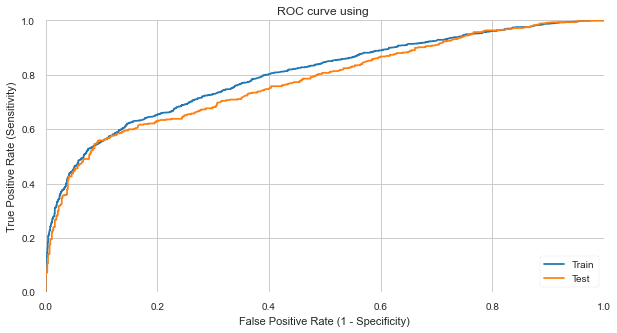

In [69]:
# Generate ROC
plt.subplots(figsize=(10, 5))
train_prob = final_mod_GBM.predict_proba(X_train)[:, 1]
test_prob = final_mod_GBM.predict_proba(X_test)[:, 1]

plot_roc_curve(y_train, train_prob,
               y_test, test_prob)

In [70]:
# make predictions for test data
y_pred = final_mod_GBM.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 76.25%


# Apply GBM on New Data Created above

In [71]:
# Get the new dataset in the same order of the variables used in train
new_data_final = new_data[best_model.variables]
new_data.head()

Age  Default  Balance  HHInsurance  CarLoan  LastContactDay  NoOfContacts  \
0   25        0        1            1        1              12            12   
1   40        0        0            1        1              24             1   
2   44        0    -1313            1        1              15            10   
3   27        0     6279            1        0               9             1   
4   53        0     7984            1        0               2             1   

   DaysPassed  PrevAttempts  Job_None  ...  LastContactMonth_jun  \
0          -1             0         0  ...                     0   
1          -1             0         0  ...                     0   
2          -1             0         0  ...                     0   
3          -1             0         0  ...                     0   
4          -1             0         0  ...                     0   

   LastContactMonth_mar  LastContactMonth_may  LastContactMonth_nov  \
0                     0                     1                     0   
1                     0                     0                     0   
2                     0                     1                     0   
3                     0                     0                     1   
4                     0                     0                     0   

   LastContactMonth_oct  LastContactMonth_sep  Outcome_NoPrev  \
0                     0                     0               1   
1                     0                     0               1   
2                     0                     0               1   
3                     0                     0               1   
4                     0                     0               1   

   Outcome_failure  Outcome_other  Outcome_success  
0                0              0                0  
1                0              0                0  
2                0              0                0  
3                0              0                0  
4                0              0                0  

[5 rows x 46 columns]

In [72]:
# Predict on the new data
new_data_final['Predicted'] = best_model.predict(new_data_final)
new_data_final.head()

Age  Default  Balance  HHInsurance  CarLoan  LastContactDay  NoOfContacts  \
0   25        0        1            1        1              12            12   
1   40        0        0            1        1              24             1   
2   44        0    -1313            1        1              15            10   
3   27        0     6279            1        0               9             1   
4   53        0     7984            1        0               2             1   

   DaysPassed  PrevAttempts  Job_None  ...  LastContactMonth_mar  \
0          -1             0         0  ...                     0   
1          -1             0         0  ...                     0   
2          -1             0         0  ...                     0   
3          -1             0         0  ...                     0   
4          -1             0         0  ...                     0   

   LastContactMonth_may  LastContactMonth_nov  LastContactMonth_oct  \
0                     1                     0                     0   
1                     0                     0                     0   
2                     1                     0                     0   
3                     0                     1                     0   
4                     0                     0                     0   

   LastContactMonth_sep  Outcome_NoPrev  Outcome_failure  Outcome_other  \
0                     0               1                0              0   
1                     0               1                0              0   
2                     0               1                0              0   
3                     0               1                0              0   
4                     0               1                0              0   

   Outcome_success  Predicted  
0                0          0  
1                0          0  
2                0          0  
3                0          1  
4                0          0  

[5 rows x 47 columns]

In [74]:
new_data_final.to_csv('D:\\Data_science_project\\Data_science_project\\carInsurance_xgb_boosting\\Predicted_GBM.csv', index=False)

# End of Notebook